In [1]:
import sys
sys.path.append('/home/ubuntu/scripts/')

In [2]:
from starter import *

%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_SEED = 2018
random.seed(RANDOM_SEED)

## Load data

In [5]:
consumption_test = pd.read_csv('cold_start_test.csv', index_col=[0], parse_dates=[2])
consumption_train = pd.read_csv('consumption_train.csv', index_col=[0], parse_dates=[2])
meta = pd.read_csv('new_meta.csv', index_col=[0], converters={'days_off':str})
submission_format = pd.read_csv('new_submission_format.csv', index_col=[0], parse_dates=[2])

In [6]:
df = consumption_train.copy()
df['train'] = 1
df = df.append(consumption_test)
df['train'].fillna(0, inplace=True)

In [7]:
consumption_columns = consumption_train.columns

Check if consumption_test and submission_format has the same series_id

In [8]:
consumption_test_o = pd.read_csv('cold_start_test.csv', index_col=[0], parse_dates=[2])
submission_format_o = pd.read_csv('new_submission_format.csv', index_col=[0], parse_dates=[2])

In [9]:
submission_format_o.series_id.nunique(), consumption_test_o.series_id.nunique()

(625, 625)

In [10]:
set(submission_format_o.series_id.unique())-set(consumption_test_o.series_id.unique())

set()

Append info prediction windows to test consumption

In [11]:
# add prediction_window to the test data
pred_windows = submission_format[['series_id', 'prediction_window']].drop_duplicates()
consumption_test = consumption_test.merge(pred_windows, on='series_id')

num_cold_start_days_provided = (consumption_test.groupby('series_id')
                                               .prediction_window
                                               .value_counts()
                                               .divide(24))

## Split into groups based on metadata

In [12]:
df_groups = pd.read_csv('new_meta.csv', index_col=0, converters={'days_off':str})

In [13]:
df_groups.days_off.value_counts()

0000011    1236
0000000     104
0000001      21
0000111      10
0000010       5
1111111       4
0011111       3
Name: days_off, dtype: int64

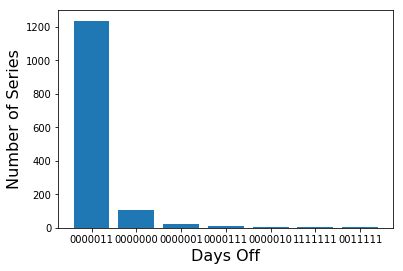

In [14]:
plt.subplots(1, 1, figsize=(6,4))
plt.bar(df_groups.days_off.value_counts().keys(), df_groups.days_off.value_counts().values)
plt.xlabel('Days Off', fontsize=16)
plt.ylabel('Number of Series', fontsize=16);

Group by surface

In [15]:
df_groups.surface.value_counts()

x-large     382
x-small     314
medium      172
xx-small    149
small       146
large       112
xx-large    108
Name: surface, dtype: int64

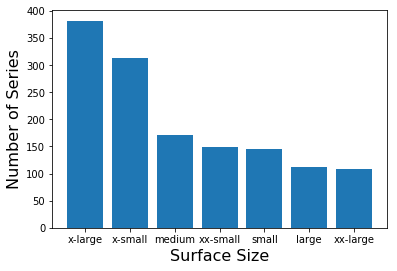

In [16]:
plt.subplots(1, 1, figsize=(6,4))
plt.bar(df_groups.surface.value_counts().keys(), df_groups.surface.value_counts().values)
plt.xlabel('Surface Size', fontsize=16)
plt.ylabel('Number of Series', fontsize=16);

In [18]:
df_groups.groupby(['days_off','surface']).aggregate('count')['series_id']

days_off  surface 
0000000   large         4
          medium       18
          small        34
          x-large       8
          x-small      29
          xx-small     11
0000001   large         2
          medium        1
          x-large      13
          xx-large      5
0000010   x-small       5
0000011   large       103
          medium      153
          small       112
          x-large     361
          x-small     280
          xx-large     89
          xx-small    138
0000111   xx-large     10
0011111   large         3
1111111   xx-large      4
Name: series_id, dtype: int64

## Feature Engineering

### Add datetime features

In [19]:
df['day_of_week'] = df['timestamp'].dt.weekday
df['hour'] = df['timestamp'].dt.hour

In [20]:
df.head()

,consumption,series_id,temperature,timestamp,train,day_of_week,hour
0,101842.233424,103088,NaN,2014-12-24 00:00:00,1.0,2,0
1,105878.048906,103088,NaN,2014-12-24 01:00:00,1.0,2,1
2,91619.105008,103088,NaN,2014-12-24 02:00:00,1.0,2,2
3,94473.706203,103088,NaN,2014-12-24 03:00:00,1.0,2,3
4,96976.755526,103088,NaN,2014-12-24 04:00:00,1.0,2,4


### Imputing Temperatures

Find the median temperature for similar surface size groups at every hour.

In [21]:
avg_temperatures = dict()

In [22]:
for group in df_groups.surface.unique():
    group_series = df_groups[df_groups.surface==group].series_id.tolist()
    series_avg_temp = df[df.series_id.isin(group_series)].groupby(['day_of_week','hour'])['temperature'].mean()
    avg_temperatures[group] = np.array(series_avg_temp).reshape(7,24)

Impute missing temperatures

In [23]:
for group in df_groups.surface.unique():
    group_series = df_groups[df_groups.surface==group].series_id.tolist()
#     impute_temp = pd.DataFrame(data={'day_of_week':np.arange(0,7,1), 'impute_temperature':avg_temperatures[group]})
    impute_temp = avg_temperatures[group]
    for d in range(7):
        for h in range(24):
            df.loc[(df.temperature.isnull())&(df.series_id.isin(group_series))&
                   (df.day_of_week==d)&(df.hour==h),'temperature'] = impute_temp[d][h]

In [24]:
temp_train_mask = df[df.series_id.isin(consumption_train.series_id.unique())].temperature != consumption_train.temperature
temp_test_mask = df[df.series_id.isin(consumption_test.series_id.unique())].temperature != consumption_test.temperature

In [25]:
consumption_train.loc[temp_train_mask, 'temperature'] = df[df.series_id.isin(consumption_train.series_id.unique())].temperature
consumption_test.loc[temp_test_mask, 'temperature'] = df[df.series_id.isin(consumption_test.series_id.unique())].temperature

In [26]:
print(set(consumption_test.series_id.unique()) - set(submission_format.series_id.unique()))
print(consumption_test.series_id.nunique(), submission_format.series_id.nunique())

set()
625 625


### Weekends and days of week

Save holiday for another time...

In [27]:
consumption_train['day_of_week'] = consumption_train['timestamp'].dt.weekday
consumption_train['hour'] = consumption_train['timestamp'].dt.hour
consumption_train.loc[consumption_train.day_of_week>5,'weekend'] = 1
consumption_train['weekend'].fillna(0, inplace=True)

consumption_test['day_of_week'] = consumption_test['timestamp'].dt.weekday
consumption_test['hour'] = consumption_test['timestamp'].dt.hour
consumption_test.loc[consumption_test.day_of_week>5,'weekend'] = 1
consumption_test['weekend'].fillna(0, inplace=True)

--------

Add days off

In [28]:
weekday_dict = {0:'monday_is_day_off', 1:'tuesday_is_day_off', 2:'wednesday_is_day_off', 3:'thursday_is_day_off', 
                4:'friday_is_day_off', 5:'saturday_is_day_off', 6:'sunday_is_day_off'}

In [20]:
list(map(lambda x: meta.loc[meta.series_id==consumption_train.loc[x,'series_id'], 
                            weekday_dict[consumption_train.loc[x,'day_of_week']]], consumption_train.index))

[1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype: int64, 1157    0
 Name: wednesday_is_day_off, dtype:

In [30]:
consumption_train.head()

,series_id,timestamp,consumption,temperature,day_of_week,hour,weekend
0,103088,2014-12-24 00:00:00,101842.233424,15.759585,2,0,0.0
1,103088,2014-12-24 01:00:00,105878.048906,15.358927,2,1,0.0
2,103088,2014-12-24 02:00:00,91619.105008,14.943660,2,2,0.0
3,103088,2014-12-24 03:00:00,94473.706203,14.588253,2,3,0.0
4,103088,2014-12-24 04:00:00,96976.755526,14.301696,2,4,0.0


In [61]:
# initialize day off as 0
consumption_train['day_off'] = 0
consumption_test['day_off'] = 0

# indicate day off based on metadata
for day in range(7):
    consumption_train.loc[(consumption_train.series_id.isin(meta[meta[weekday_dict[day]]==1].series_id.tolist()))&
                         (consumption_train.day_of_week==day),'day_off'] = 1
    consumption_test.loc[(consumption_test.series_id.isin(meta[meta[weekday_dict[day]]==1].series_id.tolist()))&
                        (consumption_test.day_of_week==day),'day_off'] = 1

---------

## Model Building

In [63]:
def describe_training_data(train_df):
    num_training_series = train_df.series_id.nunique()
    num_training_days = num_training_series * 28
    num_training_hours = num_training_days * 24
    assert num_training_hours == train_df.shape[0]
    
    desc = f'There are {num_training_series} training ' \
           f'series totaling {num_training_days} days ' \
           f'({num_training_hours} hours) of consumption data.'
    
    print(desc)

In [64]:
# choose subset of series to use
frac_series_to_use = 0.05
rng = np.random.RandomState(seed=RANDOM_SEED)
series_ids = consumption_train.series_id.unique()
series_mask = rng.binomial(1,
                           frac_series_to_use,
                           size=series_ids.shape).astype(bool)
training_series = series_ids[series_mask]

# reduce training data to series subset
consumption_train = consumption_train[consumption_train.series_id.isin(training_series)]

# describe the reduced set
describe_training_data(consumption_train)

There are 39 training series totaling 1092 days (26208 hours) of consumption data.


In [65]:
len(training_series), consumption_train.series_id.nunique(), consumption_test.series_id.nunique()

(39, 39, 625)

# IGNORE BELOW UNTIL NOTIFIED

-----------

## Create prediction windows for test set

Create training set first

In [20]:
pred_groups = pd.DataFrame(data={'series_id':test_series, 'prediction_window':[random.choice(['hourly','daily','weekly']) for _ in range(len(test_series))]})
test_window = pred_groups.merge(
    consumption_test[consumption_test.series_id==pred_groups.series_id.values.tolist()[0]]
                                .iloc[:50,:], on='series_id', how='inner')
for i in pred_groups.series_id.values.tolist()[1:]:
    test_window = pd.concat([test_window, pred_groups.merge(
        consumption_test[consumption_test.series_id==i].iloc[:50,:], on='series_id', how='inner')])

In [21]:
def create_scoring_format(train_hours=40, pred_hours=10):
    pred_scoring = test_window[test_window.series_id==pred_groups.series_id.values.tolist()[0]][train_hours:train_hours+pred_hours]
    for j in pred_groups.series_id.values.tolist()[1:]:
        pred_scoring = pd.concat([pred_scoring, test_window[test_window.series_id==j][train_hours:train_hours+pred_hours]])
    pred_scoring.set_index('timestamp', inplace=True)
    return pred_scoring

In [22]:
pred_scoring = create_scoring_format()

In [27]:
# map_window = {'daily':7,'hourly':14,'weekly':2}
# test_window['total_row'] = test_window.apply(
#     lambda row: map_window[row['prediction_window']], axis=1)

In [28]:
print('Unique series_id: ', test_window.series_id.nunique())
# all([x==14 for x in test_window[test_window.prediction_window=='hourly'].groupby('series_id').size()])
# all([x==7 for x in test_window[test_window.prediction_window=='daily'].groupby('series_id').size()])
# all([x==2 for x in test_window[test_window.prediction_window=='weekly'].groupby('series_id').size()])

Unique series_id:  11


## Explore data

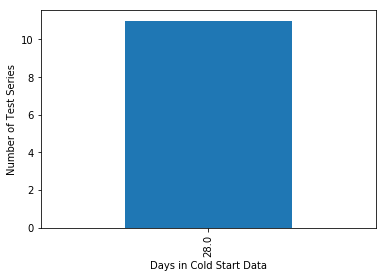

In [35]:
ax = (consumption_test.groupby('series_id').count()
                                           .timestamp
                                           .divide(24)
                                           .value_counts()
                                           .sort_index()
                                           .plot.bar())
ax.set_xlabel('Days in Cold Start Data')
ax.set_ylabel('Number of Test Series')
plt.show()

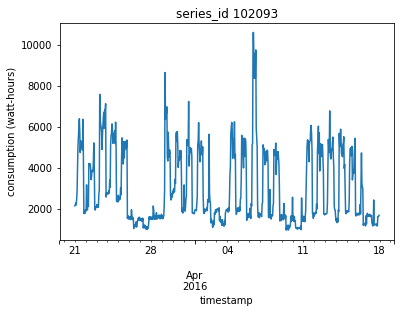

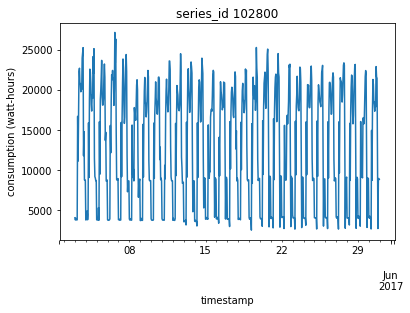

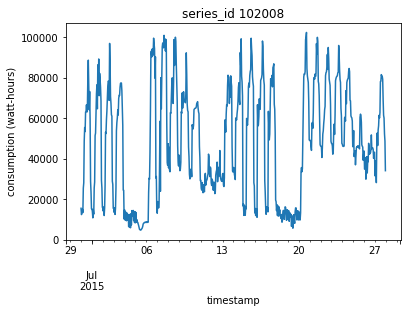

In [36]:
# plot a few consumption patterns
series_to_plot = rng.choice(consumption_train.series_id.unique(), 3)

for ser_id in series_to_plot:
    ser_data = consumption_train[consumption_train.series_id == ser_id]
    ax = ser_data.plot(x='timestamp',
                       y='consumption', 
                       title=f"series_id {int(ser_id)}",
                       legend=False)
    plt.ylabel('consumption (watt-hours)')
    plt.show()

In [37]:
(consumption_train.groupby('series_id')
                  .timestamp
                  .apply(lambda x: x.max() - x.min())
                  .value_counts())

27 days 23:00:00    28
Name: timestamp, dtype: int64

-------

# RESUME

## Set up data for model

In [66]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
from subprocess import check_output

from tqdm import tqdm

Using TensorFlow backend.


In [115]:
def create_lagged_features(df, features=['consumption','temperature','weekend','day_off'], lag=1):
    if not type(df) == pd.DataFrame:
        df = pd.DataFrame(df, columns=features)
    
    def _rename_lag(ser, j):
        ser.name = ser.name + f'_{j}'
        return ser
        
    # add a column lagged by `i` steps
    for i in range(1, lag + 1):
        df = df.join(df.consumption.shift(i).pipe(_rename_lag, i))
        df = df.join(df.temperature.shift(i).pipe(_rename_lag, i))
        df = df.join(df.weekend.shift(i).pipe(_rename_lag, i))
        df = df.join(df.day_off.shift(i).pipe(_rename_lag, i))
        
    df.dropna(inplace=True)
    return df

In [85]:
def prepare_training_data(consumption_series, lag):
    """ Converts a series of consumption data into a
        lagged, scaled sample.
    """
    # scale training data
    scaler = MinMaxScaler(feature_range=(-1, 1))
#     consumption_vals = scaler.fit_transform(consumption_series.values.reshape(-1, 1))
    consumption_vals = scaler.fit_transform(consumption_series.values)
    
    # convert consumption series to lagged features
    consumption_lagged = create_lagged_features(consumption_vals, features=consumption_series.columns, lag=lag)

    # X, y format taking the first column (original time series) to be the y
    X = consumption_lagged.drop('consumption', axis=1).values
    y = consumption_lagged.consumption.values
    
    # keras expects 3 dimensional X
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    return X, y, scaler

In [70]:
# try example set
example_series = consumption_train[consumption_train.series_id == training_series[0]].reset_index(drop=True)
example_series.index = example_series.timestamp
create_lagged_features(example_series[['consumption','temperature','weekend']], lag=3).head()

,consumption,temperature,weekend,consumption_1,temperature_1,weekend_1,consumption_2,temperature_2,weekend_2,consumption_3,temperature_3,weekend_3
timestamp,,,,,,,,,,,,
2017-06-07 03:00:00,562464.244579,14.588253,0.0,570699.933083,14.943660,0.0,561278.342934,15.358927,0.0,527862.165731,15.759585,0.0
2017-06-07 04:00:00,565464.153881,14.301696,0.0,562464.244579,14.588253,0.0,570699.933083,14.943660,0.0,561278.342934,15.358927,0.0
2017-06-07 05:00:00,593757.048480,14.104140,0.0,565464.153881,14.301696,0.0,562464.244579,14.588253,0.0,570699.933083,14.943660,0.0
2017-06-07 06:00:00,606651.971117,14.038189,0.0,593757.048480,14.104140,0.0,565464.153881,14.301696,0.0,562464.244579,14.588253,0.0
2017-06-07 07:00:00,570132.762731,14.491973,0.0,606651.971117,14.038189,0.0,593757.048480,14.104140,0.0,565464.153881,14.301696,0.0


In [71]:
_X, _y, scaler = prepare_training_data(example_series[['consumption','temperature','weekend']], 12)
print(_X.shape)
print(_y.shape)
print(scaler)

(660, 1, 38)
(660,)
MinMaxScaler(copy=True, feature_range=(-1, 1))


## Fit model

In [97]:
def set_model_basic(lag=24, num_neurons=24, batch_size=1, n_layers=1):
    # model parameters
    n_features = 4*(lag+1)-1
    batch_input_shape=(batch_size, 1, n_features)
    
    # instantiate a sequential model
    model = Sequential()

    # add LSTM layer - stateful MUST be true here in 
    # order to learn the patterns within a series
    model.add(LSTM(units=num_neurons, 
                  batch_input_shape=batch_input_shape, 
                  stateful=True))
    # followed by a dense layer with a single output for regression
    model.add(Dense(1))
    
    #compile
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    return model

In [98]:
def set_model_tanh(lag=24, num_neurons=24, batch_size=1, n_layers=1):
    # model parameters
    batch_input_shape=(batch_size, 1, lag)
    
    #set up model
    model = Sequential()
#     if n_layers==1:
#         model.add(LSTM(units=num_neurons[0], batch_input_shape=batch_input_shape, stateful=True, dropout=0.2))
#     elif n_layers>1:
#         model.add(LSTM(units=num_neurons[0], batch_input_shape=batch_input_shape, stateful=True, return_sequences=True, dropout=0.2))
#         for i in range(n_layers-1):
#             model.add(LSTM(units=num_neurons[i+1], stateful=True, activation='relu', dropout=0.2))
    if n_layers==1:
        model.add(LSTM(units=num_neurons, batch_input_shape=batch_input_shape, stateful=True, dropout=0.2))
    elif n_layers>1:
        
        for i in range(n_layers-1):
            model.add(LSTM(units=num_neurons, batch_input_shape=batch_input_shape, stateful=True, return_sequences=True, dropout=0.2))
        model.add(LSTM(units=num_neurons, stateful=True, activation='tanh', dropout=0.2))    
    
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    return model

In [99]:
def set_model_relu(lag=24, num_neurons=24, batch_size=1, n_layers=1):
    # model parameters
    batch_input_shape=(batch_size, 1, lag)
    
    #set up model
    model = Sequential()
#     if n_layers==1:
#         model.add(LSTM(units=num_neurons[0], batch_input_shape=batch_input_shape, stateful=True, dropout=0.2))
#     elif n_layers>1:
#         model.add(LSTM(units=num_neurons[0], batch_input_shape=batch_input_shape, stateful=True, return_sequences=True, dropout=0.2))
#         for i in range(n_layers-1):
#             model.add(LSTM(units=num_neurons[i+1], stateful=True, activation='relu', dropout=0.2))
    if n_layers==1:
        model.add(LSTM(units=num_neurons, batch_input_shape=batch_input_shape, stateful=True, dropout=0.2))
    elif n_layers>1:
        
        for i in range(n_layers-1):
            model.add(LSTM(units=num_neurons, batch_input_shape=batch_input_shape, stateful=True, return_sequences=True, dropout=0.2))
        model.add(LSTM(units=num_neurons, stateful=True, activation='relu', dropout=0.2))    
    
    model.add(Dense(1))
    model.compile(loss='mean_absolute_error', optimizer='adam')
    
    return model

In [100]:
for i in consumption_train.series_id.unique()[:10]:
    shape_train = consumption_train[consumption_train.series_id==i].shape[0]
    print(shape_train, int(shape_train)/24)

672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0
672 28.0


In [112]:
def fit_model(model, train_data, n_epochs=3, batch_size=1, lag=12):
    """ Fits model on training data on each series_id with specified
        number of epochs.
    """
    for i in tqdm(range(n_epochs), total=n_epochs, desc='Learning Consumption Trends - Epochs'):
        
        # reset the LSTM state for training on each series
        for ser_id, ser_data in train_data.groupby('series_id'):
            # prepare the data
            X, y, scaler = prepare_training_data(ser_data[['consumption','temperature','weekend','day_off']], lag)
            #fit the model
            model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
#             model.fit(X, y, epochs=1, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]),
#                       verbose=1, shuffle=False)
            model.reset_states()
    return model

In [143]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag, batch_size):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # indicate number of features
    n_features = 4*(lag+1)-1
    
   # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
#     X = scaler.transform(consumption.values)[-lag:]
    X = scaler.transform(consumption.values).reshape(-1,1)[-1*n_features:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, n_features), batch_size=batch_size)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 4)).ravel()
    return hourly_preds

In [78]:
series_data = consumption_test.loc[consumption_test.series_id == 100283, ['consumption','temperature','weekend']]

In [211]:
# preds_scaled = np.zeros(14)
X = scaler.transform(series_data)[-lag:]

In [213]:
scaler.transform(series_data.values).reshape(-1,1)[-lag*3+1:].shape

(35, 1)

In [139]:
X.reshape(1, lag, 3)

array([[[ 5.60289908e+00,  6.88862221e-01, -1.00000000e+00],
        [ 4.39585872e+00,  8.58041596e-01, -1.00000000e+00],
        [ 3.58216430e+00,  9.48569260e-01, -1.00000000e+00],
        [ 3.72483224e+00,  1.00000000e+00, -1.00000000e+00],
        [ 3.64967059e+00,  9.35289476e-01, -1.00000000e+00],
        [ 3.66351982e+00,  7.82809672e-01, -1.00000000e+00],
        [ 3.45188411e+00,  5.97766568e-01, -1.00000000e+00],
        [ 3.52607144e+00,  4.08442928e-01, -1.00000000e+00],
        [ 3.65266314e+00,  1.94618776e-01, -1.00000000e+00],
        [ 4.35799952e+00, -3.07904882e-03, -1.00000000e+00],
        [ 4.74703063e+00, -1.72592049e-01, -1.00000000e+00],
        [ 3.37366033e+00, -3.23544825e-01, -1.00000000e+00]]])

In [ ]:
preds = generate_hourly_forecast(14, series_data, model, scaler, lag)

In [104]:
# num_pred_hours = 10
# num_test_series = consumption_test.series_id.nunique()
# for ser_id, pred_df in tqdm(consumption_test.groupby('series_id'),
#                            total=num_test_series,
#                            desc='Forecasting from Cold Start Data'):
#     series_data = consumption_test[consumption_test.series_id==ser_id].consumption[:20]
#     cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
#     model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
#     y_pred = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)
#     y_real = consumption_test[consumption_test.series_id==ser_id].consumption[20:]
#     model.reset_states()
#     print(RMSE(y_real, y_pred))

In [144]:
def generate_complete_forecast(model, test_data, submission, lag=24, batch_size=1):
    # set definitions of prediction windows
    pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
    pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}
    
    num_test_series = submission.series_id.nunique()
    model.reset_states()
    
    for ser_id, pred_df in tqdm(submission.groupby('series_id'),
                               total=num_test_series,
                               desc="Forecasting from Cold Start Data"):
        
        # get info about this series' prediction window
        pred_window = pred_df.prediction_window.unique()[0]
        num_preds = pred_window_to_num_preds[pred_window]
        num_pred_hours = pred_window_to_num_pred_hours[pred_window]
        
        # prepare cold start data
        series_data = consumption_test[consumption_test.series_id == ser_id].consumption
        cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
        
        # fine tune our lstm model to this site using cold start data    
        model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)

        # make hourly forecasts for duration of pred window
        preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)

        # reduce by taking sum over each sub window in pred window
        reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]

        # store result in submission DataFrame
        ser_id_mask = my_submission.series_id == ser_id
        my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds
        
    return model, my_submission

In [145]:
def run_experiment(train, test, lag, num_neurons, batch_size, n_epochs, n_layers, train_hours=40, pred_hours=10):
    # set up model architecture
    pred_scoring = create_scoring_format()
    model = set_model(lag=lag, num_neurons=num_neurons, batch_size=batch_size, n_layers=n_layers)
    
    # fit model on training data
    model = fit_model(model, train, n_epochs=n_epochs, batch_size=batch_size)
    
    num_pred_hours = pred_hours
    num_test_series = test.series_id.nunique()
    scores = []
    
    for ser_id, pred_df in tqdm(test.groupby('series_id'),
                           total=num_test_series,
                           desc='Forecasting from Cold Start Data'):
        series_data = test[test.series_id==ser_id].consumption[:train_hours]
        cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
        model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        y_pred = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)
        y_real = test[test.series_id==ser_id].consumption[train_hours:train_hours+pred_hours]
        model.reset_states()
        pred_scoring.loc[pred_scoring.series_id==ser_id,'prediction'] = y_pred
        scores.append(RMSE(y_real, y_pred))
    
    return model, scores, pred_scoring

In [146]:
def RMSE(y, pred):
    return mean_squared_error(y, pred)**0.5

def MAE(y, pred):
    return sum([abs(i) for i in (y-pred)])/y.shape[0]

-----

In [181]:
group_series = meta.loc[meta.days_off=='0000011', 'series_id'].unique().tolist()
group_train = consumption_train[consumption_train.series_id.isin(group_series)]
model = set_model_basic(lag=lag, num_neurons=num_neurons, batch_size=batch_size)


In [205]:
ser_data = group_train.loc[group_train.series_id==103585, ['consumption','temperature','weekend']]

In [206]:
X, y, scaler = prepare_training_data(ser_data[['consumption','temperature','weekend']], 12)

In [207]:
model = set_model_basic(lag=lag, num_neurons=num_neurons, batch_size=batch_size)

In [208]:
model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)

In [ ]:
for ser_id, ser_data in train_data.groupby('series_id'):
    X, y, scaler = prepare_training_data(ser_data[['consumption','temperature','']])

In [182]:
model = fit_model(model, group_train, n_epochs=2, batch_size=batch_size)

Learning Consumption Trends - Epochs:   0%|          | 0/2 [00:00<?, ?it/s]


ValueError: Error when checking input: expected lstm_4_input to have shape (1, 12) but got array with shape (1, 38)

# GOLDEN CODE TO PREDICT BY GROUPS

------

In [ ]:
# set parameters
lag = 12
num_neurons = 100
batch_size = 1
n_epochs = 1

In [148]:
model_dict = dict()
my_submission = submission_format.copy()

In [149]:
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

In [153]:
for group in meta.surface.unique():
    
    # create list of series_id in the group
    group_series = meta.loc[meta.surface==group,'series_id'].unique().tolist()
    # select train data that belong in the days off group
    group_train = consumption_train[consumption_train.series_id.isin(group_series)]
    # set basic model architecture
    model = set_model_basic(lag=lag, num_neurons=num_neurons, batch_size=batch_size)
    # fit model to training data
    model = fit_model(model, group_train, n_epochs=n_epochs, batch_size=batch_size, lag=lag)
    # create submission dataframe belonging in the group
    this_submission = my_submission[my_submission.series_id.isin(group_series)]

    num_test_series = this_submission.series_id.nunique()
    model.reset_states()
    
    for ser_id, pred_df in tqdm(this_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        # get info about this series' prediction window
        pred_window = pred_df.prediction_window.unique()[0]
        num_preds = pred_window_to_num_preds[pred_window]
        num_pred_hours = pred_window_to_num_pred_hours[pred_window]
        
        # prepare cold start data
        series_data = consumption_test.loc[consumption_test.series_id == ser_id, ['consumption','temperature','weekend','day_off']]
        cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
        
        # fine tune our lstm model to this site using cold start data    
        model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        
        # make hourly forecasts for duration of pred window
        preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)
        
        # reduce by taking sum over each sub window in pred window
        reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]

        # store result in submission DataFrame
        ser_id_mask = my_submission.series_id == ser_id
        my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

Forecasting from Cold Start Data: 100%|██████████| 70/70 [00:36<00:00,  2.46it/s]


-----

In [117]:
series_data = consumption_test.loc[consumption_test.series_id == ser_id, ['consumption','temperature','weekend','day_off']]
cold_X, cold_y, scaler = prepare_training_data(series_data, lag)

In [118]:
# fine tune our lstm model to this site using cold start data    
model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)

In [119]:
# make hourly forecasts for duration of pred window
preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag, batch_size)

ValueError: non-broadcastable output operand with shape (336,1) doesn't match the broadcast shape (336,4)

In [125]:
n_features = 4*(lag+1)-1
preds_scaled=np.zeros(num_pred_hours)

In [127]:
X = scaler.transform(series_data.values).reshape(-1,1)[-1*n_features:]

In [130]:
for i in range(num_pred_hours):
    # predict scaled value for next time step
    yhat = model.predict(X.reshape(1, 1, n_features), batch_size=batch_size)[0][0]
    preds_scaled[i] = yhat

    # update X to be latest data plus prediction
    X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

In [147]:
scaler.inverse_transform(preds_scaled.reshape(-1,4))

array([3.58686987e+05, 3.18350664e+01, 2.00975984e-01, 9.31350887e-02,
       3.52887381e+05, 3.23877711e+01, 1.84883326e-01, 8.87885988e-02,
       3.39602242e+05, 3.29352040e+01, 1.60844445e-01, 7.54670799e-02,
       3.46658467e+05, 3.31431204e+01, 1.47373289e-01, 7.65925348e-02,
       3.39467100e+05, 3.29487356e+01, 1.36422098e-01, 6.77619874e-02,
       3.44388570e+05, 3.33860575e+01, 1.60774469e-01, 7.69790411e-02,
       3.62403676e+05, 3.27651549e+01, 1.59249842e-01, 8.38854611e-02,
       3.69197458e+05, 3.12200510e+01, 1.43252730e-01, 8.44017565e-02,
       3.83290315e+05, 2.98089233e+01, 1.33171648e-01, 1.02551818e-01,
       3.49774766e+05, 2.97956596e+01, 1.48936987e-01, 9.44820046e-02,
       2.98409418e+05, 2.74448308e+01, 1.08702987e-01, 7.01291561e-02,
       2.88280264e+05, 2.55034271e+01, 1.13348454e-01, 6.59063160e-02,
       3.06757900e+05, 3.14278439e+01, 3.54937404e-01, 1.09431326e-01,
       3.18831780e+05, 3.22405422e+01, 3.20449680e-01, 9.55317020e-02,
      

In [137]:
series_data.shape

(96, 4)

In [131]:
X.shape

(51,)

In [113]:
def generate_hourly_forecast(num_pred_hours, consumption, model, scaler, lag, batch_size):
    """ Uses last hour's prediction to generate next for num_pred_hours, 
        initialized by most recent cold start prediction. Inverts scale of 
        predictions before return.
    """
    # indicate number of features
    n_features = 4*(lag+1)-1
    
   # allocate prediction frame
    preds_scaled = np.zeros(num_pred_hours)
    
    # initial X is last lag values from the cold start
#     X = scaler.transform(consumption.values)[-lag:]
    X = scaler.transform(consumption.values).reshape(-1,1)[-1*n_features:]
    
    # forecast
    for i in range(num_pred_hours):
        # predict scaled value for next time step
        yhat = model.predict(X.reshape(1, 1, n_features), batch_size=batch_size)[0][0]
        preds_scaled[i] = yhat
        
        # update X to be latest data plus prediction
        X = pd.Series(X.ravel()).shift(-1).fillna(yhat).values

    # revert scale back to original range
    hourly_preds = scaler.inverse_transform(preds_scaled.reshape(-1, 4)).ravel()
    return hourly_preds

How to ravel....and fit in proper shape

-------

------

In [ ]:
%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = consumption_test[consumption_test.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

In [56]:
# set up model architecture
model = set_model_basic(lag=lag, num_neurons=num_neurons, batch_size=batch_size)

# fit model on training data
model = fit_model(model, consumption_train, n_epochs=n_epochs, batch_size=batch_size)


Learning Consumption Trends - Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/1
660/660 [==============================] - 1s 1ms/step - loss: 0.3047
Epoch 1/1
660/660 [==============================] - 0s 363us/step - loss: 0.3714
Epoch 1/1
660/660 [==============================] - 0s 359us/step - loss: 0.4232
Epoch 1/1
660/660 [==============================] - 0s 361us/step - loss: 0.2563
Epoch 1/1
660/660 [==============================] - 0s 364us/step - loss: 0.2400
Epoch 1/1
660/660 [==============================] - 0s 358us/step - loss: 0.2395
Epoch 1/1
660/660 [==============================] - 0s 358us/step - loss: 0.2871
Epoch 1/1
  4/660 [..............................] - ETA: 0s - loss: 0.2668

KeyboardInterrupt: 

In [30]:
# copy submission format and fill in values
my_submission = submission_format.copy()
model, my_submission = generate_complete_forecast(model, consumption_test, my_submission, lag=lag, batch_size=batch_size)

Forecasting from Cold Start Data: 100%|██████████| 625/625 [13:19<00:00,  1.28s/it]


In [31]:
my_submission[my_submission.prediction_window == 'hourly'].consumption.describe()

count    5.808000e+03
mean     1.661096e+05
std      6.193884e+05
min     -3.393037e+04
25%      1.511113e+04
50%      3.704044e+04
75%      9.533242e+04
max      5.095149e+06
Name: consumption, dtype: float64

In [32]:
my_submission[my_submission.prediction_window == 'daily'].consumption.describe()

count    1.337000e+03
mean     3.406911e+06
std      9.819808e+06
min     -1.137587e+04
25%      4.271856e+05
50%      9.248156e+05
75%      2.730388e+06
max      1.156378e+08
Name: consumption, dtype: float64

In [33]:
my_submission[my_submission.prediction_window == 'weekly'].consumption.describe()

count    3.840000e+02
mean     2.435026e+07
std      6.639902e+07
min     -1.357406e+06
25%      2.819529e+06
50%      7.594946e+06
75%      2.026643e+07
max      7.481041e+08
Name: consumption, dtype: float64

In [36]:
my_submission.loc[my_submission.consumption<0,'consumption']=0

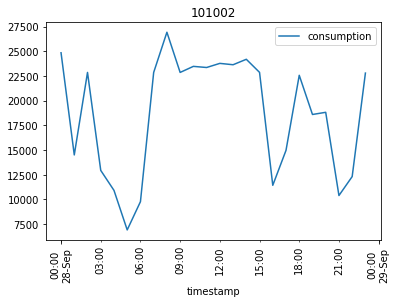

In [37]:
# plot samples
sample_ser = (my_submission[my_submission.prediction_window == 'hourly']
                           .series_id
                           .sample().values[0])

(my_submission[my_submission.series_id == sample_ser]
              .plot(x='timestamp',
                    y='consumption',
                    title=sample_ser,
                    rot=90))

In [38]:
my_submission.iloc[:,:-1].to_csv("submissions/my_submmission_20181001_2.csv", index_label='pred_id')

-------

In [156]:
def create_train_test(train_size, test_size, data, limit=5800):
    train = data[:train_size]
    test  = data[train_size:limit]
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(train)
    train = scaler.transform(train)
    test = scaler.transform(test)
    return scaler, train, test

In [157]:
def split_train_test(train, test):
    # Split into input and outputs 
    train_X, train_y = train[:,:-5], train[:,-5:]
    test_X, test_y = test[:, :-5], test[:, -5:]
    # LSTM requires 3D data sets: [samples, timesteps, features]
    total_features = train_X.shape[1]
    train_X = train_X.reshape(train_X.shape[0],7,int(total_features/7))
    test_X = test_X.reshape(test_X.shape[0], 7,int(total_features/7))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    
    return train_X, train_y, test_X, test_y

In [60]:
def fit_lstm(train_X, train_y, layers=3, n_batch=50, n_neurons=100, n_epochs=100, n_output=1, dropout=0):
    model = Sequential()
    model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]),
                 stateful=True, activation='tanh', return_sequences=True))
    for i in range(layers-2):
        model.add(LSTM(n_neurons, stateful=True, activation='tanh', return_sequences=True, dropout=dropout))
    model.add(LSTM(n_neurons, stateful=True, activation='relu', dropout=dropout))
    model.add(Dense(n_output))
    model.compile(loss='mse', optimizer='adam')
    for i in range(int(train_X.shape[0] / n_batch)):
        this_X = train_X[(i * n_batch):((i + 1) * n_batch)][:][:]
        this_y = train_y[(i * n_batch):((i + 1) * n_batch)]
        history = model.fit(this_X, this_y, epochs=n_epochs, 
                                    batch_size=n_batch, 
                                    verbose=1, shuffle=False)
        model.reset_states()
    return model, history, n_batch

In [61]:
def evaluate_model(model, test_X, test_y, scaler, n_batch, n_samples=1):

    y_pred = [test_X.shape[0]]
    for i in range(int(test_X.shape[0] / n_batch)):
        this_X = test_X[(i * n_batch):((i + 1) * n_batch)][:][:]
        this_pred = model.predict(this_X, batch_size=n_batch)    
        y_pred[(i * n_batch):((i + 1) * n_batch)] = [list(i) for i in this_pred]
    
    test_X_nn = test_X.reshape((test_X.shape[0], test_X.shape[1]*test_X.shape[2]))
    # Invert scaling for forecast
    inv_y_pred = np.concatenate((y_pred, test_X_nn[:, :]), axis=1)
    inv_y_pred = scaler.inverse_transform(inv_y_pred)
    inv_y_pred = inv_y_pred[:,:5]
    inv_y_pred = np.round(np.maximum(inv_y_pred, 0))
    # Invert scaling for actual
    test_y_nn = test_y.reshape((len(test_y), 5))
    inv_y = np.concatenate((test_y_nn, test_X_nn[:, :]), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,:5]
    # print scores
    print(inv_y_pred[:10])
    print(inv_y[:10])
    rmse = dict()
    for i in range(n_samples):
        rmse[i] = RMSE([m[i]/4 for m in inv_y], [n[i]/4 for n in inv_y_pred])
        print('Test RMSE: %.3f' % rmse[i])
    
    return rmse, inv_y_pred, inv_y

In [62]:
def append_prediction(df, prediction):
    pred_df = df.iloc[-prediction.shape[0]-26:-26,:]
#     pred_df = df.iloc[-prediction.shape[0]-33:-33,:]
    for i in range(prediction.shape[1]):
        pred_df['prediction{}'.format(i)] = [x[i] for x in prediction]
    return pred_df

In [63]:
def append_baseline(data, n_samples):
    baseline = dict()
    for i in range(n_samples):
        baseline[i] = data.iloc[:5100,:].groupby(['hour'])['swaps{}'.format(i)].quantile(.75)
        baseline[i] = baseline[i].reset_index()
        baseline[i].rename(columns={'swaps{}'.format(i):'baseline{}'.format(i)}, inplace=True)
        data = data.merge(baseline[i], on='hour', how='left')
    return data

In [64]:
def plot_forecast_multi(data, range_lower=-700, range_upper=None, n_samples=1):
    plt.subplots(n_samples, 1, figsize=(20,6*n_samples))
    for i in range(n_samples):
        plt.subplot(n_samples, 1, i+1)
        plt.plot(data.iloc[range_lower:range_upper].index, np.round(data.iloc[range_lower:range_upper,i]/4), label='Real')
        plt.plot(data.iloc[range_lower:range_upper].index, np.round(data.iloc[range_lower:range_upper,list(data.columns).index('prediction{}'.format(i))]/4), label='Predict')
        plt.plot(data.iloc[range_lower:range_upper].index, np.round(data.iloc[range_lower:range_upper,list(data.columns).index('baseline{}'.format(i))]/4), label='Baseline')
        plt.xlabel('Date Time', fontsize=16)
        plt.ylabel('Swaps', fontsize=16)
        plt.legend();

In [65]:
def run_experiment(vmlist, layers, n_batch, n_neurons, n_epochs, dropout):
    #select GoStations to forecast
    df_station = df[df.vmid.isin(vmlist)]
    df_station = pd.pivot_table(df_station, values='swaps', index='datetime', columns='vmid')
    df_station['hour'] = df_station.index.hour
    
    #rename columns
    cols = df_station.columns
    for n, i in enumerate(cols[:-1]):
        df_station.rename(columns={i:'swaps'+str(n)}, inplace=True)
        
    prep_df = pd.concat([df_station[list(df_station.columns)[:-1]], pd.get_dummies(df_station['hour'], prefix='hour')], axis=1)
    prep_df.loc[prep_df.index.dayofweek>4, 'weekend'] = 1
    prep_df['weekend'].fillna(0, inplace=True)
    cols = prep_df.columns
    tmp = pd.DataFrame(series_to_supervised(prep_df, 7, 1))
    tmp.drop(tmp.columns[-(prep_df.shape[1] - len(vmlist)):], axis=1, inplace=True)
    super_data = tmp
    
    #split train/test set and scale
    scaler, train, test = create_train_test(5100, len(super_data)-5100-26, super_data)
    train_X, train_y, test_X, test_y = split_train_test(train, test)
    
    #train model
    model, history, n_batch = fit_lstm(train_X, train_y, layers, n_batch, n_neurons, n_epochs, len(vmlist), dropout)
    rmse, inv_y_pred, inv_y = evaluate_model(model, test_X, test_y, scaler, n_batch, len(vmlist))
    
    #create dataframe with all predictions and real data
    pred_prep_df = append_prediction(prep_df, inv_y_pred)
    pred_prep_df['hour']=pred_prep_df.index.hour
    pred_index = pred_prep_df.index
    pred_prep_df = append_baseline(pred_prep_df, len(vmlist))
    pred_prep_df.index = pred_index
    
    hyperparam = pd.DataFrame(data={'layers':[layers],'batch_size':[n_batch],'neurons':[n_neurons],'epochs':[n_epochs],'dropout':[dropout],
                   'RMSE0':[rmse[0]],'RMSE1':[rmse[1]],'RMSE2':[rmse[2]],'RMSE3':[rmse[3]],'RMSE4':[rmse[4]]})
    
    return pred_prep_df, hyperparam

In [66]:
def append_results(df, vmlist, layers, n_batch, n_neurons, n_epochs, dropout):
    pred_prep_df, hyperparam = run_experiment(vmlist, layers, n_batch, n_neurons, n_epochs, dropout)
    df = df.append(hyperparam)
    return df, pred_prep_df

--------

In [192]:
# lag of 24 to simulate smallest cold start window. Our series
# will be converted to a num_timesteps x lag size matrix
lag =  24

# model parameters
num_neurons = 24
batch_size = 1  # this forces the lstm to step through each time-step one at a time
batch_input_shape=(batch_size, 1, lag)

# instantiate a sequential model
model = Sequential()

# add LSTM layer - stateful MUST be true here in 
# order to learn the patterns within a series
model.add(LSTM(units=num_neurons, 
              batch_input_shape=batch_input_shape, 
              stateful=True))

# followed by a dense layer with a single output for regression
model.add(Dense(1))

# compile
model.compile(loss='mean_absolute_error', optimizer='adam')

In [129]:
%%time
num_training_series = consumption_train.series_id.nunique()
num_passes_through_data = 3

for i in tqdm(range(num_passes_through_data), 
              total=num_passes_through_data, 
              desc='Learning Consumption Trends - Epoch'):
    
    # reset the LSTM state for training on each series
    for ser_id, ser_data in consumption_train.groupby('series_id'):

        # prepare the data
        X, y, scaler = prepare_training_data(ser_data.consumption, lag)

        # fit the model: note that we don't shuffle batches (it would ruin the sequence)
        # and that we reset states only after an entire X has been fit, instead of after
        # each (size 1) batch, as is the case when stateful=False
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=1, shuffle=False)
        model.reset_states()

Learning Consumption Trends - Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1114
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1520
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1415
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1346
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1105
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1320
Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1142
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1187
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1007
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1112


Learning Consumption Trends - Epoch:  33%|███▎      | 1/3 [00:14<00:28, 14.12s/it]

Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.0959
Epoch 1/1
648/648 [==============================] - 2s 3ms/step - loss: 0.1438
Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1425
Epoch 1/1
648/648 [==============================] - 2s 3ms/step - loss: 0.1332
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1060
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1288
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1093
Epoch 1/1
648/648 [==============================] - 2s 2ms/step - loss: 0.1164
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.0994
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1090


Learning Consumption Trends - Epoch:  67%|██████▋   | 2/3 [00:29<00:14, 14.72s/it]

Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.0968
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1421
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1420
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1324
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1050
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1263
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1099
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1160
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1006
Epoch 1/1
648/648 [==============================] - 1s 2ms/step - loss: 0.1091


Learning Consumption Trends - Epoch: 100%|██████████| 3/3 [00:42<00:00, 14.11s/it]

CPU times: user 1min 1s, sys: 12 s, total: 1min 13s
Wall time: 42.4 s


In [115]:
%%time
pred_window_to_num_preds = {'hourly': 24, 'daily': 7, 'weekly': 2}
pred_window_to_num_pred_hours = {'hourly': 24, 'daily': 7 * 24, 'weekly': 2 * 7 * 24}

num_test_series = my_submission.series_id.nunique()

model.reset_states()

for ser_id, pred_df in tqdm(my_submission.groupby('series_id'), 
                            total=num_test_series, 
                            desc="Forecasting from Cold Start Data"):
        
    # get info about this series' prediction window
    pred_window = pred_df.prediction_window.unique()[0]
    num_preds = pred_window_to_num_preds[pred_window]
    num_pred_hours = pred_window_to_num_pred_hours[pred_window]
    
    # prepare cold start data
    series_data = consumption_test[consumption_test.series_id == ser_id].consumption
    cold_X, cold_y, scaler = prepare_training_data(series_data, lag)
    
    # fine tune our lstm model to this site using cold start data    
    model.fit(cold_X, cold_y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
    
    # make hourly forecasts for duration of pred window
    preds = generate_hourly_forecast(num_pred_hours, series_data, model, scaler, lag)
    
    # reduce by taking sum over each sub window in pred window
    reduced_preds = [pred.sum() for pred in np.split(preds, num_preds)]
    
    # store result in submission DataFrame
    ser_id_mask = my_submission.series_id == ser_id
    my_submission.loc[ser_id_mask, 'consumption'] = reduced_preds

Forecasting from Cold Start Data: 100%|██████████| 625/625 [05:53<00:00,  1.77it/s]

CPU times: user 7min 17s, sys: 1min 2s, total: 8min 19s
Wall time: 5min 53s
